<a href="https://colab.research.google.com/github/1hamzaiqbal/MFCLIP_acv/blob/hamza%2Fdiscrim/vit_train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT Generator Training - Clean Notebook

This notebook trains 3 variants of the ViT-based adversarial generator:

1. **targeted_only**: Targeted attack loss only (minimize loss for target class)
2. **contrastive**: Targeted + Full contrastive loss (maximize feature distance)
3. **mixed**: Targeted + Weighted contrastive loss (adjustable weight)

**Key Fixes Applied:**
- Uses TRAIN set (not test set) for training
- Reduced batch size to avoid OOM on 22.5GB VRAM
- Proper checkpoint saving to Google Drive
- Training history tracking and visualization


In [1]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Create output directory structure
import os
DRIVE_OUTPUT = "/content/drive/MyDrive/grad/comp_vision/hanson_loss"
os.makedirs(f"{DRIVE_OUTPUT}/oxford_pets", exist_ok=True)
os.makedirs(f"{DRIVE_OUTPUT}/food101", exist_ok=True)
print(f"Output directory: {DRIVE_OUTPUT}")


Mounted at /content/drive
Output directory: /content/drive/MyDrive/grad/comp_vision/hanson_loss


In [ ]:
# Cell 2: Setup Repository & Dependencies
!nvidia-smi
%cd /content

import os
if not os.path.exists("MFCLIP_acv"):
    !git clone -b hamza/discrim https://github.com/1hamzaiqbal/MFCLIP_acv

%cd MFCLIP_acv
!git fetch --all
!git reset --hard origin/hamza/discrim

# Install dependencies
!pip install -q torch torchvision timm einops yacs tqdm opencv-python \
    scikit-learn scipy pyyaml ruamel.yaml pytorch-ignite foolbox \
    pandas matplotlib seaborn wilds ftfy


Mon Dec  1 02:22:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   35C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Cell 3: Setup Oxford Pets Dataset & Surrogate Checkpoint
import shutil
import os
from pathlib import Path
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

DATA_ROOT = "/content/data"
PETS_ROOT = f"{DATA_ROOT}/oxford_pets"
DRIVE_OUTPUT = "/content/drive/MyDrive/grad/comp_vision/hanson_loss"

# Create directories
Path(PETS_ROOT).mkdir(parents=True, exist_ok=True)

# Download dataset via torchvision (creates split files)
print("Setting up Oxford Pets dataset...")
_ = OxfordIIITPet(root=PETS_ROOT, download=True, transform=transforms.ToTensor())

# Also fetch raw images and annotations (needed by dataloader)
%cd /content
if not os.path.exists(f"{PETS_ROOT}/images"):
    print("Downloading images and annotations...")
    !wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    !tar -xf images.tar.gz -C {PETS_ROOT}
    !tar -xf annotations.tar.gz -C {PETS_ROOT}
    !rm -f images.tar.gz annotations.tar.gz
print("✓ Dataset ready!")

# Copy pre-trained RN50 surrogate checkpoint from Drive
SURROGATE_SRC = f"{DRIVE_OUTPUT}/oxford_pets/RN50_ArcFace_oxford_pets.pth"
SURROGATE_DST = f"{PETS_ROOT}/RN50_ArcFace.pth"

if os.path.exists(SURROGATE_SRC):
    shutil.copy(SURROGATE_SRC, SURROGATE_DST)
    print(f"✓ Surrogate checkpoint copied to {SURROGATE_DST}")
else:
    print(f"⚠️  WARNING: Surrogate not found at {SURROGATE_SRC}")
    print("   You need to train the surrogate first using finetune mode.")
    print("   Or copy your existing RN50_ArcFace checkpoint to Google Drive.")


Setting up Oxford Pets dataset...


100%|██████████| 792M/792M [00:49<00:00, 16.0MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 9.32MB/s]


/content
✓ Dataset ready!
✓ Surrogate checkpoint copied to /content/data/oxford_pets/RN50_ArcFace.pth


## Training Configuration

Adjust batch size if you get OOM errors. The default of 32 should work on 22.5GB VRAM.


In [4]:
# Cell 4: Training Configuration
CONFIG = {
    'dataset': 'oxford_pets',
    'num_epochs': 150,       # Reduced for faster training
    'batch_size': 32,        # Reduced to avoid OOM (lower if needed)
    'learning_rate': 0.001,  # Good for AdamW
    'eps': 16,               # Epsilon for perturbation
    'surrogate': 'RN50',
    'head': 'ArcFace',
}

print("Training Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")


Training Configuration:
  dataset: oxford_pets
  num_epochs: 150
  batch_size: 32
  learning_rate: 0.001
  eps: 16
  surrogate: RN50
  head: ArcFace


## Train Variant 1: Targeted Only

This variant only uses the targeted classification loss (minimize loss for target class).


In [5]:
# Cell 5: Train - Targeted Only (No Contrastive Loss)
%cd /content/MFCLIP_acv

!python main.py \
    --flag train_unet \
    --generator vit \
    --dataset oxford_pets \
    --root /content/data \
    --config-file configs/trainers/CoOp/rn50.yaml \
    --dataset-config-file configs/datasets/oxford_pets.yaml \
    --trainer ZeroshotCLIP \
    --surrogate RN50 \
    --head ArcFace \
    --loss_mode targeted_only \
    --num_epoch 150 \
    --bs 32 \
    --lr 0.001 \
    --eps 16 \
    --device cuda:0


/content/MFCLIP_acv
2025-12-01 02:25:19.383022: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 02:25:19.399615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764555919.423039    2815 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764555919.429682    2815 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764555919.446411    2815 computation_placer.cc:177] computation placer already registered. Please check linkag

## Train Variant 2: Full Contrastive

Targeted + Full contrastive loss (weight=1.0). Maximizes feature distance between clean and adversarial images.


In [6]:
# Cell 6: Train - Full Contrastive (Targeted + Contrastive w/ weight=1.0)
%cd /content/MFCLIP_acv

!python main.py \
    --flag train_unet \
    --generator vit \
    --dataset oxford_pets \
    --root /content/data \
    --config-file configs/trainers/CoOp/rn50.yaml \
    --dataset-config-file configs/datasets/oxford_pets.yaml \
    --trainer ZeroshotCLIP \
    --surrogate RN50 \
    --head ArcFace \
    --loss_mode contrastive \
    --contrastive_weight 1.0 \
    --num_epoch 150 \
    --bs 32 \
    --lr 0.001 \
    --eps 16 \
    --device cuda:0


/content/MFCLIP_acv
2025-12-01 03:36:20.439395: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 03:36:20.457373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764560180.479095   30972 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764560180.485561   30972 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764560180.502218   30972 computation_placer.cc:177] computation placer already registered. Please check linkag

## Train Variant 3: Mixed Loss

Targeted + Weighted contrastive (weight=0.5). A balance between targeted attack and feature disruption.


In [7]:
# Cell 7: Train - Mixed (Targeted + Contrastive w/ weight=0.5)
%cd /content/MFCLIP_acv

!python main.py \
    --flag train_unet \
    --generator vit \
    --dataset oxford_pets \
    --root /content/data \
    --config-file configs/trainers/CoOp/rn50.yaml \
    --dataset-config-file configs/datasets/oxford_pets.yaml \
    --trainer ZeroshotCLIP \
    --surrogate RN50 \
    --head ArcFace \
    --loss_mode mixed \
    --contrastive_weight 0.5 \
    --num_epoch 150 \
    --bs 32 \
    --lr 0.001 \
    --eps 16 \
    --device cuda:0


/content/MFCLIP_acv
2025-12-01 04:59:31.147987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 04:59:31.165930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764565171.187534   61956 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764565171.194081   61956 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764565171.210848   61956 computation_placer.cc:177] computation placer already registered. Please check linkag

## Save Checkpoints to Google Drive


In [8]:
# Cell 8: Save All Checkpoints to Google Drive
import shutil
import os

DATA_ROOT = "/content/data/oxford_pets"
DRIVE_OUTPUT = "/content/drive/MyDrive/grad/comp_vision/hanson_loss/oxford_pets"

checkpoints = [
    "vit_generator_targeted_only.pt",
    "vit_generator_contrastive.pt",
    "vit_generator_mixed.pt",
    "vit_generator_targeted_only_history.json",
    "vit_generator_contrastive_history.json",
    "vit_generator_mixed_history.json",
]

print("Copying checkpoints to Google Drive...")
for ckpt in checkpoints:
    src = f"{DATA_ROOT}/{ckpt}"
    dst = f"{DRIVE_OUTPUT}/{ckpt}"
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"  ✓ {ckpt}")
    else:
        print(f"  ✗ {ckpt} (not found)")

print(f"\nDone! Checkpoints saved to: {DRIVE_OUTPUT}")


Copying checkpoints to Google Drive...
  ✓ vit_generator_targeted_only.pt
  ✓ vit_generator_contrastive.pt
  ✓ vit_generator_mixed.pt
  ✓ vit_generator_targeted_only_history.json
  ✓ vit_generator_contrastive_history.json
  ✓ vit_generator_mixed_history.json

Done! Checkpoints saved to: /content/drive/MyDrive/grad/comp_vision/hanson_loss/oxford_pets


## Plot Training Histories

Compare loss and accuracy curves across the 3 variants.


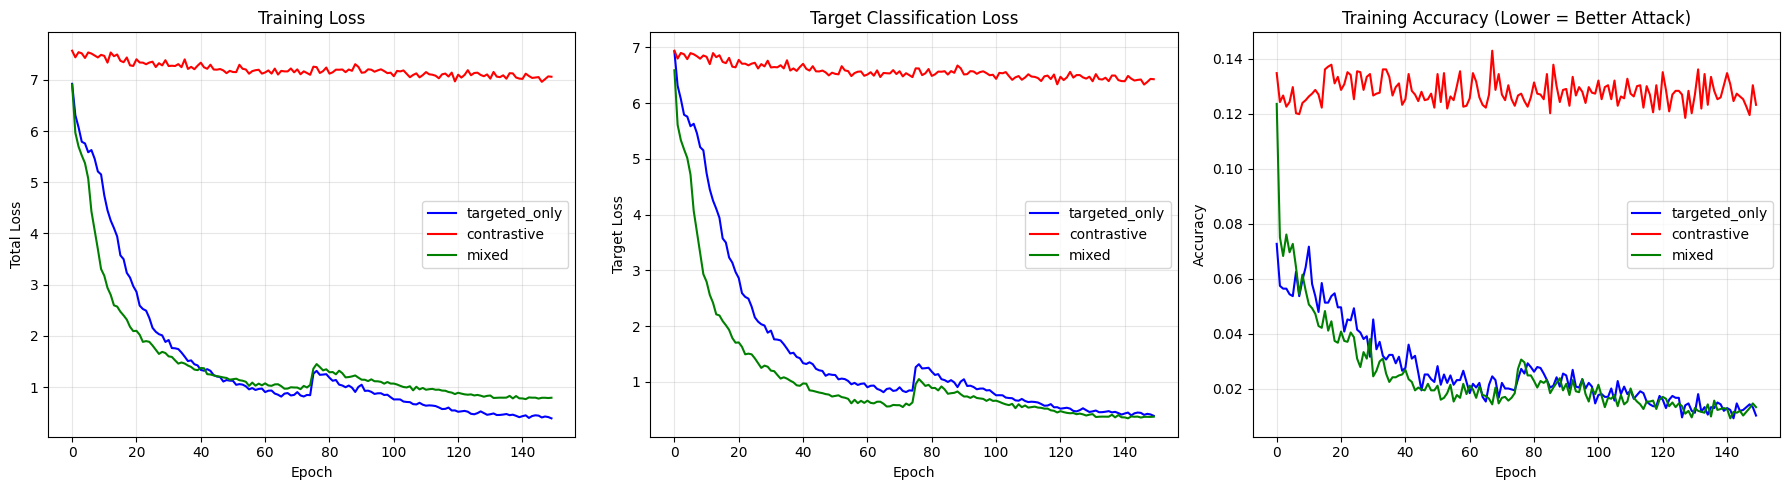

Plot saved to training_comparison.png


In [9]:
# Cell 9: Plot Training Histories
import json
import matplotlib.pyplot as plt
import os

DATA_ROOT = "/content/data/oxford_pets"

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

histories = {
    'targeted_only': None,
    'contrastive': None,
    'mixed': None,
}

colors = {'targeted_only': 'blue', 'contrastive': 'red', 'mixed': 'green'}

# Load histories
for mode in histories.keys():
    path = f"{DATA_ROOT}/vit_generator_{mode}_history.json"
    if os.path.exists(path):
        with open(path, 'r') as f:
            histories[mode] = json.load(f)

# Plot 1: Total Loss
ax = axes[0]
for mode, hist in histories.items():
    if hist:
        ax.plot(hist['epoch'], hist['loss'], label=mode, color=colors[mode])
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Loss')
ax.set_title('Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Target Loss
ax = axes[1]
for mode, hist in histories.items():
    if hist and 'loss_target' in hist:
        ax.plot(hist['epoch'], hist['loss_target'], label=mode, color=colors[mode])
ax.set_xlabel('Epoch')
ax.set_ylabel('Target Loss')
ax.set_title('Target Classification Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Accuracy
ax = axes[2]
for mode, hist in histories.items():
    if hist:
        ax.plot(hist['epoch'], hist['acc'], label=mode, color=colors[mode])
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training Accuracy (Lower = Better Attack)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DATA_ROOT}/training_comparison.png", dpi=150)
plt.show()

print("Plot saved to training_comparison.png")
